<h1 style="font-size: 30px; color: burlywood;"> Kalman Filter Testing for quadcopter's altitude estimation</h1>

<h3>Import libraries and functions</h3>

In [1]:
from kalmanAltitude import KalmanAltitude2D
import numpy  as np
import pandas as pd
from scipy.linalg import inv
import matplotlib.pyplot as plt

<h3>Load raw data and do preprocessing</h3>

In [2]:
# Define constants
Ts = 0.03
g_si = 9.80665 # earth gravitational acceleration

In [3]:
# Load csv data -- acceleration(z)
csvFile = 'accelerometer.csv'

# Convert it to NumPy array 
df    = pd.read_csv(csvFile)
array = df.to_numpy()

# Get z-axis acceleration (filtered) 
acc_z = df.iloc[:, 1].to_numpy().reshape(-1, 1) # [m/s^2]

acc_z -= np.mean(acc_z) # CORRECT DC OFFSET 

# Get z-axis acceleration (raw)
acc_zRaw = df.iloc[:, 0].to_numpy().reshape(-1, 1) # [m/s^2]

acc_zRaw -= np.mean(acc_zRaw) # CORRECT DC OFFSET 

In [4]:
# Create time vector
time = np.arange(0.0, len(acc_z)*Ts, Ts)
time = time.reshape(-1,1)

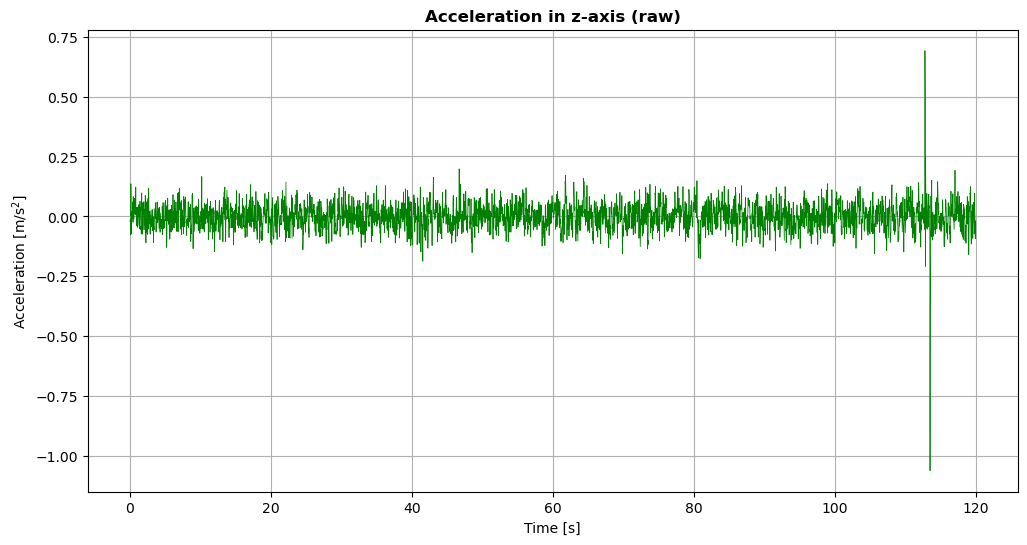

In [5]:
# Plot z-axis acceleration
plt.figure(figsize=(12,6))
plt.plot(time, acc_z, 'g', linewidth = 0.55)
plt.title('Acceleration in z-axis (raw)',  fontweight="bold")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s${^2}$]")
plt.grid()

In [6]:
# Load csv data -- pressure
csvFile = 'baroP.csv'

# Convert it to NumPy array 
df    = pd.read_csv(csvFile)
array = df.to_numpy()

# Get barometric pressure (raw)
pressure_baro = df.iloc[:, 0].to_numpy().reshape(-1, 1) # [mbar]
pressure_baro = pressure_baro[0:len(time)]

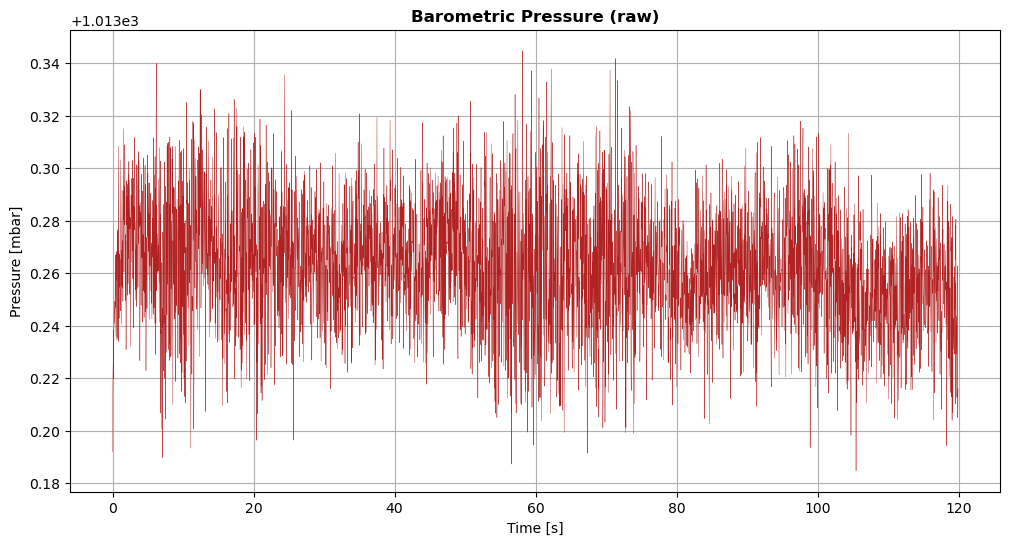

In [7]:
# Plot Barometric Pressure
plt.figure(figsize=(12,6))
plt.plot(time, pressure_baro,'firebrick', linewidth = 0.3)
plt.title('Barometric Pressure (raw)',  fontweight="bold")
plt.xlabel("Time [s]")
plt.ylabel("Pressure [mbar]")
plt.grid()

In [8]:
# Load csv data -- altitude
csvFile = 'altitude.csv'

# Convert it to NumPy array 
df    = pd.read_csv(csvFile)
array = df.to_numpy()

# Get calculated height (filtered) 
h_baro = df.iloc[:, 1].to_numpy().reshape(-1, 1) # [m]

# Get calculated height (raw) 
h_baroRaw = df.iloc[:, 0].to_numpy().reshape(-1, 1) # [m]

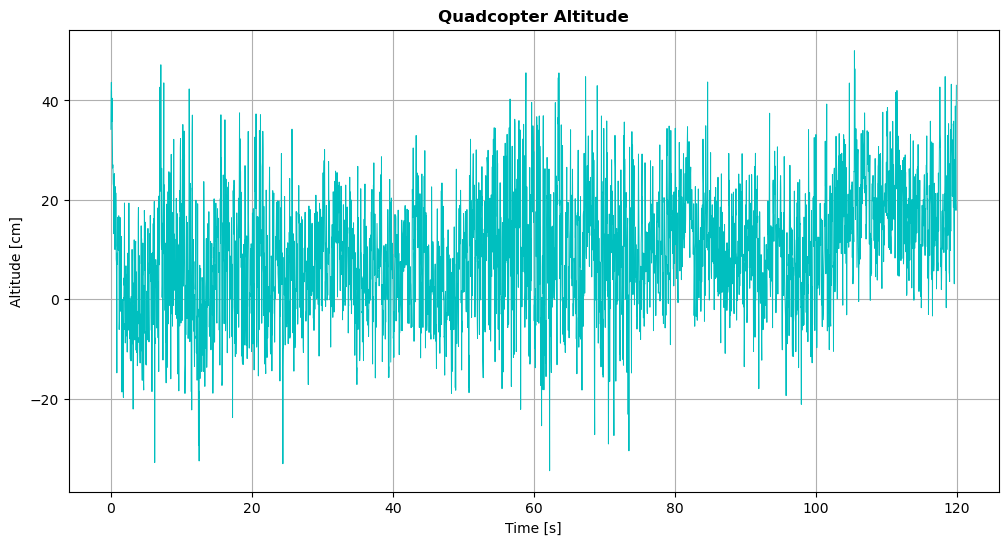

In [9]:
# Plot height from baro
plt.figure(figsize=(12,6))
plt.plot(time, h_baro*100, 'c', linewidth = 0.7)
plt.title("Quadcopter Altitude", fontweight="bold")
plt.xlabel("Time [s]")
plt.ylabel("Altitude [cm]")
plt.grid()

<h2 style="font-size=1;">Main Kalman Loop </h2>

0. Set initial values<br>
$\hat{x}_{0},\ P_{0}$
<br><br>
1. Predict state & error covariance<br>
$\hat{x}_{k}^{-} = A\hat{x}_{k-1}$<br>
$P_{k}^{-} = AP_{k-1}A^{T} + Q$
<br><br>
2. Compute Kalman Gain<br>
$K_{k} = P_{k}^{-}H^{T}(HP_{k}^{-}H^{T}+R)^{-1}$
<br><br>
3. Compute the estimate<br>
$\tilde{y}_{k} = z_{k} - H\hat{x}_{k-1}$<br>
$\hat{x}_{k} = \hat{x}_{k}^{-} + K_{k}\tilde{y}_{k}$
<br><br>
4. Compute the error covariance<br>
$P_{k} = P_{k}^{-} - K_{k}HP_{k}^{-}$
<br><br>

$\ \ \ \ \ \ \  \textbf{return}$ $\hat{x}_{k} , \ P_{k}$ 

In [10]:
# Define Initial Conditions
x_EstPrev = np.array([[0.0],
                      [0.0]])        # zero for both x and P means that we know exactly our system's 
                                     # position and velocity (steady at the beginning)
P_EstPrev = np.array([[0.0, 0.0],    
                      [0.0, 0.0]])

# Initialize z_Kalman, zDot_Kalman
z_Kalman = np.zeros((len(time),1))
zDot_Kalman = np.zeros((len(time),1))

for i in range(len(time)):
    x_Kalman,P_NextEst = KalmanAltitude2D(h_baro[i], acc_z[i], x_EstPrev, P_EstPrev, Ts) 
    x_EstPrev = x_Kalman   
    P_EstPrev = P_NextEst
    
    z_Kalman[i]    = x_Kalman[0]
    zDot_Kalman[i] = x_Kalman[1]

<h2 style="font-size=1;">Plot Kalman Filter results</h2>

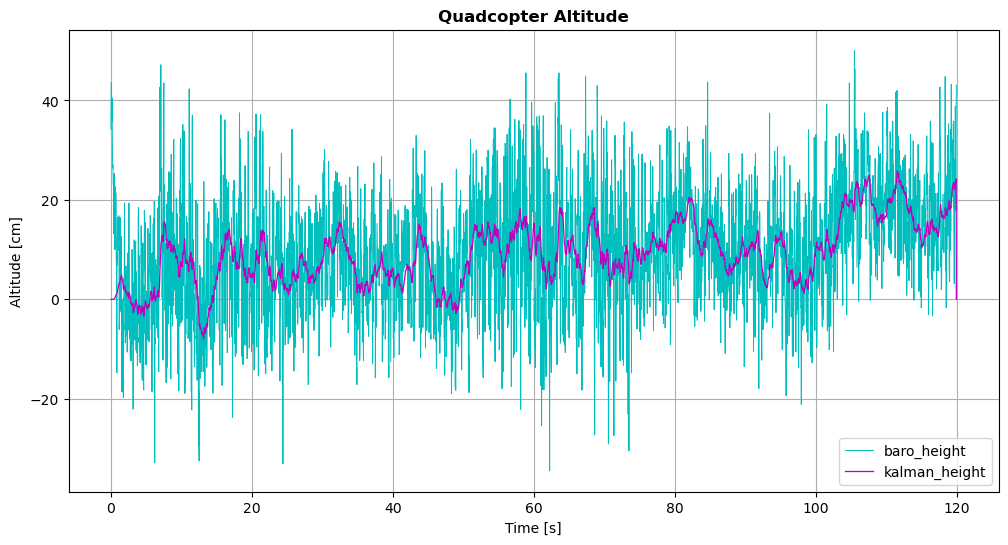

In [12]:
# Plot  height from baro & Kalman height
plt.figure(figsize=(12,6))
plt.plot(time, h_baro*100, 'c', linewidth = 0.7)
plt.plot(time, z_Kalman*100, 'm', linewidth = 0.9)
plt.title("Quadcopter Altitude",  fontweight="bold")
plt.legend(["baro_height", "kalman_height"])
plt.xlabel("Time [s]")
plt.ylabel("Altitude [cm]")
plt.grid()

<h2 style="font-size=1;">Compare results for position</h2>

System Model

\begin{align*}
\begin{bmatrix}
\hat{z}_{k+1} \\
\hat{\dot{z}}_{k+1}
\end{bmatrix}
&=
\begin{bmatrix}
1 & T_{s}\\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
\hat{z}_{k} \\
\hat{\dot{z}}_{k}
\end{bmatrix}
+
\begin{bmatrix}
0.5T_{s}^2 \\
T_{s}
\end{bmatrix}
\ddot{z}_{k,\text{acc}}
+
w_{k}
\end{align*}


\begin{align}
y_{k} = [1 \ \ \ 0]x_{k} + v_{k}
\end{align}



In [13]:
# Derive position and velocity from system model

# State Space system model 
A = np.array([[1.0, Ts],
              [0,    1]])

B = np.array([[0.5*pow(Ts,2)], 
              [Ts]])

## Test Raw data ##
# Initialize state
x_EstPrev = np.array([[0], 
                      [0]])

accPos    =  np.zeros((len(time),1))
accVel    =  np.zeros((len(time),1))

# Test raw acceleration data
for i in range(0, len(time)-1):
    x_PredFromRaw =  A @ x_EstPrev + B * acc_z[i]     # x_Pred --> [z z']
    x_EstPrev     = x_PredFromRaw
    
    accPos[i]    = x_PredFromRaw[0]
    accVel[i]    = x_PredFromRaw[1]


In [14]:
# Calculate position from accelerometer using Z-Transform

h_fromAcc  = np.zeros((len(time),1))

for i in range(1, len(time)):
    h_fromAcc[i] = h_fromAcc[i-1] + Ts**2 * (0.25*acc_z[i] + 0.5*acc_z[i-1] + 0.25*acc_z[i-2]) 

In [15]:
# Calculate Mean Squared Error for position & display

# True position
truePos = np.zeros((len(time),1))

# MSE
accPosMSE    = np.square(np.subtract(truePos,accPos)).mean() 
baroPosMSE   = np.square(np.subtract(truePos,h_baro)).mean() 
kalmanPosMSE = np.square(np.subtract(truePos,z_Kalman)).mean() 

print([accPosMSE, baroPosMSE, kalmanPosMSE])

[1.0412028683785601, 0.023703128420276866, 0.012225191248332844]


Text(0.95, 0.07, '$accPosMSE$ = 1.041203\n$baroPosMSE$ = 0.023703\n$kalmanPosMSE$ = 0.012225')

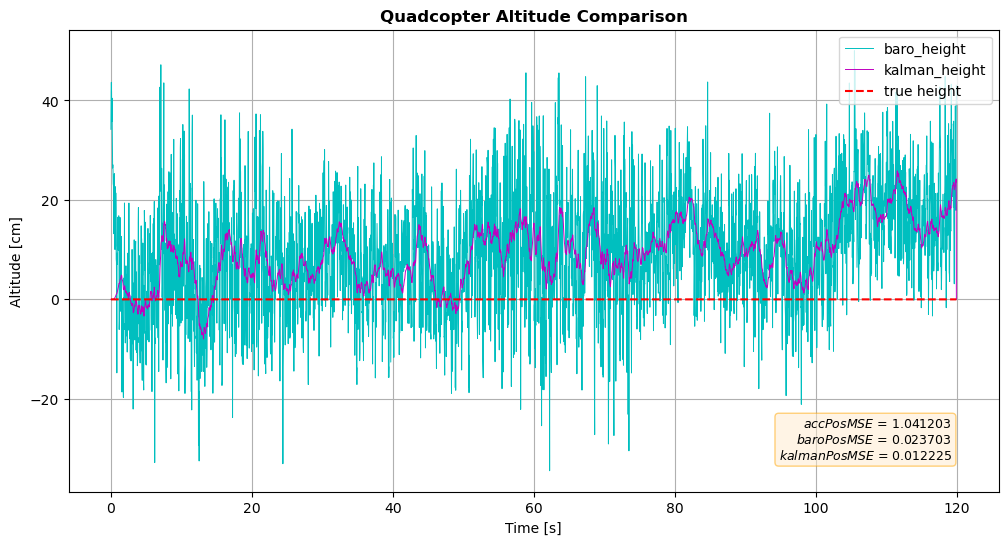

In [16]:
# Plot altitude

# 1) Only from accelerometer through model (double int)
# 2) Only from barometric pressure sensor through conversion
# 3) From Kalman Filter using sensor fusion

fig, ax = plt.subplots(figsize=(12,6))


ax.plot(time, h_baro*100, 'c', linewidth = 0.7)
ax.plot(time, z_Kalman*100, 'm', linewidth = 0.7)

ax.plot(time, truePos, '--r', linewidth = 1.5)
# ax.plot(time, accPos*100, 'g', linewidth = 0.7)

# ax.plot(time, h_fromAcc*100, 'g', linewidth = 0.7)

ax.set_title("Quadcopter Altitude Comparison",  fontweight="bold")
ax.legend(["baro_height", "kalman_height","true height","acc_height"], loc='upper right')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Altitude [cm]")
ax.grid()

stats = (f'$accPosMSE$ = {accPosMSE:.6f}\n'
         f'$baroPosMSE$ = {baroPosMSE:.6f}\n'
         f'$kalmanPosMSE$ = {kalmanPosMSE:.6f}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox, transform=ax.transAxes, horizontalalignment='right')

<h2 style="font-size=1;">Compare results for velocity</h2>

In [17]:
# Calculate velocity from baro_h

# Filtered derivative [METHOD 1 - Z-Transform]
# baroVel = np.zeros((len(time),1))
# tau = 1
# a = Ts*tau+1 # free parameter (0 to 1)
# for i in range(1,len(time)):
#     baroVel[i] = (baroVel[i-1] + h_baro[i]*Ts)/a
    
# Filtered derivative [METHOD 2 - CR circuit]
baroVel = np.zeros((len(time),1))
a = 1/(1+Ts) # free parameter (0 to 1)
for i in range(1,len(time)):
    baroVel[i] = a*baroVel[i-1] + a*(h_baro[i] - h_baro[i-1]) # HPF

In [18]:
# Calculate Mean Squared Error for velocity & display

# True velocity
trueVel = np.zeros((len(time),1))

# MSE
accVelMSE    = np.square(np.subtract(trueVel,accVel)).mean() 
baroVelMSE   = np.square(np.subtract(trueVel,baroVel)).mean() 
kalmanVelMSE = np.square(np.subtract(trueVel,zDot_Kalman)).mean() 

print([accVelMSE, baroVelMSE, kalmanVelMSE])

[0.0007964594818958172, 0.011520738720168202, 0.000684781504376488]


Text(0.95, 0.07, '$accVelMSE$ = 0.000796\n$baroVelMSE$ = 0.011521\n$kalmanVelMSE$ = 0.000685')

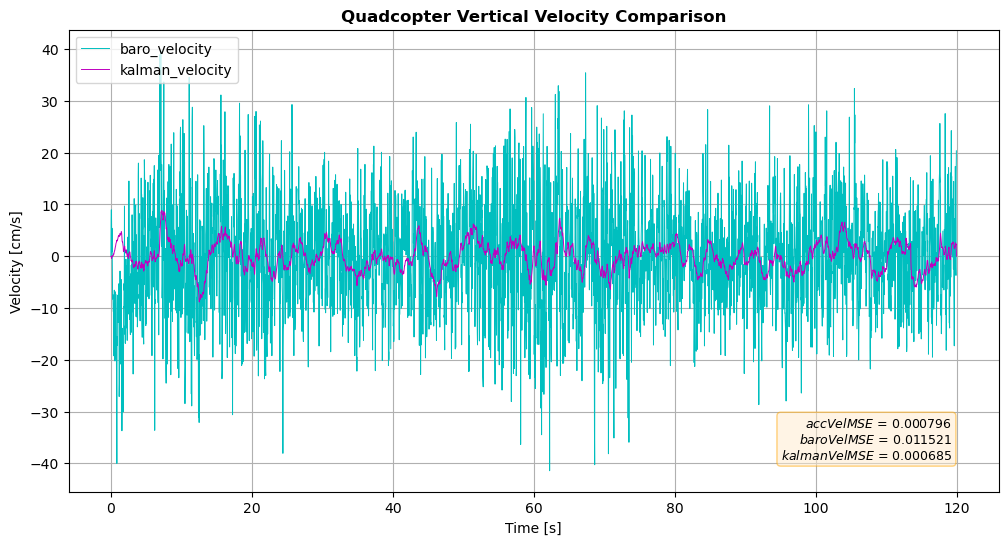

In [19]:
# Plot velocity

# 1) Only from accelerometer through model (single int)
# 2) Only from barometric pressure sensor through conversion & then derivative
# 3) From Kalman Filter using sensor fusion

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(time, baroVel*100, 'c' ,linewidth = 0.7)
ax.plot(time, zDot_Kalman*100, 'm', linewidth = 0.7)
#ax.plot(time, accVel*100, 'g',linewidth = 0.7)
#ax.plot(time, trueVel*100, '--r', linewidth = 1.5)


ax.set_title("Quadcopter Vertical Velocity Comparison",  fontweight="bold")
ax.legend(["baro_velocity","kalman_velocity", "acc_velocity","true velocity"], loc = 'upper left')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Velocity [cm/s]")
ax.grid(True)

stats = (f'$accVelMSE$ = {accVelMSE:.6f}\n'
             f'$baroVelMSE$ = {baroVelMSE:.6f}\n'
             f'$kalmanVelMSE$ = {kalmanVelMSE:.6f}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox,
        transform=ax.transAxes, horizontalalignment='right')